# 0. Basic Setup

In [ ]:
import yfinance as yf
import pandas as pd

def load_price_data(tickers, start="2019-01-01", end="2024-01-01"):

    # Download adjusted close prices for Zuser-selected tickers.

    df = yf.download(tickers, start=start, end=end, auto_adjust=False)

    # utilized AI to debug and generated this multiIndex case

    # Case 1: MultiIndex columns (multiple tickers)
    if isinstance(df.columns, pd.MultiIndex):
        # Check level 0 contains "Adj Close"
        if "Adj Close" in df.columns.levels[0]:
            df = df["Adj Close"]
        else:
            raise KeyError("Downloaded data has no 'Adj Close' field for multi-ticker input.")

    # Case 2: Single ticker (regular DataFrame)
    else:
        if "Adj Close" in df.columns:
            df = df[["Adj Close"]]
            df.columns = tickers  # rename to ticker name
        else:
            raise KeyError("Downloaded data has no 'Adj Close' column for single ticker input.")

    return df.dropna()


In [ ]:
# Ask user to input tickers
user_input = input("Enter tickers separated by commas (e.g., AAPL,MSFT,NVDA,TSLA): ")

tickers = [t.strip().upper() for t in user_input.split(",")]
print("You selected:", tickers)


Enter tickers separated by commas (e.g., AAPL,MSFT,NVDA,TSLA): AAPL,MSFT,NVDA,TSLA
You selected: ['AAPL', 'MSFT', 'NVDA', 'TSLA']


In [ ]:
# load the selected data
price_df = load_price_data(tickers)

[*********************100%***********************]  10 of 10 completed


# 1. Compute log returns and correlation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_log_returns(price_df):
    # Return log price differences
    log_prices = np.log(price_df)
    return log_prices.diff().dropna()

def compute_correlation_matrix(returns_df):
    # Return correlation matrix of returns
    return returns_df.corr()

# compute returns
returns = compute_log_returns(price_df)
print(returns)

# compute correlation
corr = compute_correlation_matrix(returns)
print (corr)

Ticker          AAPL       GLD       IWM       JPM       TLT       XLE  \
Date                                                                     
2019-01-03 -0.104924  0.009025 -0.018059 -0.014314  0.011315 -0.009967   
2019-01-04  0.041803 -0.008119  0.036673  0.036202 -0.011643  0.033458   
2019-01-07 -0.002228  0.003453  0.017342  0.000695 -0.002952  0.014756   
2019-01-08  0.018883 -0.002712  0.015214 -0.001887 -0.002632  0.007705   
2019-01-09  0.016839  0.006398  0.008222 -0.001692 -0.001566  0.015718   
...              ...       ...       ...       ...       ...       ...   
2023-12-22 -0.005563  0.004425  0.009275 -0.000597 -0.004559  0.002946   
2023-12-26 -0.002845  0.007592  0.012920  0.005896  0.002839  0.008554   
2023-12-27  0.000518  0.004528  0.003522  0.005980  0.017565 -0.004443   
2023-12-28  0.002224 -0.005832 -0.003816  0.005299 -0.007290 -0.015352   
2023-12-29 -0.005439 -0.001568 -0.016455 -0.001175 -0.009061 -0.002264   

Ticker           XLF       XLI       

# 2. Build MST

In [ ]:

class UnionFind:
    def __init__(self, items):
        self.parent = {x: x for x in items}
        self.rank = {x: 0 for x in items}

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, a, b):
        ra, rb = self.find(a), self.find(b)
        if ra == rb:
            return False

        if self.rank[ra] < self.rank[rb]:
            self.parent[ra] = rb
        elif self.rank[ra] > self.rank[rb]:
            self.parent[rb] = ra
        else:
            self.parent[rb] = ra
            self.rank[ra] += 1

        return True


def build_mst_from_corr(corr_matrix):
    # Build an MST using distance = 1 - correlation
    # higher correlation, smaller distance
    names = list(corr_matrix.columns)
    edges = []

    # collect distances
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            a, b = names[i], names[j]
            # cite the below line from AI
            c = corr_matrix.loc[a, b]
            edges.append((1 - c, a, b, c))

    edges.sort(key=lambda x: x[0])

    uf = UnionFind(names)
    mst = []

    for dist, a, b, c in edges:
        if uf.union(a, b):
            mst.append((a, b, c, dist))

    return mst


def compute_mst_metrics(mst_edges):

    # Compute a few simple metrics that summarize the MST structure.

    if not mst_edges:
        # empty MST, return NaNs to avoid crashing downstream
        return {
            "tree_length": np.nan,
            "avg_correlation": np.nan,
            "max_degree": np.nan,
            "min_degree": np.nan,
        }

    # total distance of the tree
    # the lower the tree_length, the tighter the whole groups of stocks are
    tree_length = sum(dist for (a, b, c, dist) in mst_edges)

    # average correlation on MST edges
    avg_corr = float(np.mean([c for (a, b, c, dist) in mst_edges]))

    # degree of each node (number of edges connected to this node)
    # which stock is the center, which are the leafs
    degree = {}
    for a, b, c, dist in mst_edges:
        degree[a] = degree.get(a, 0) + 1
        degree[b] = degree.get(b, 0) + 1

    max_deg = max(degree.values())
    min_deg = min(degree.values())

    metrics = {
        "tree_length": tree_length,
        "avg_correlation": avg_corr,
        "max_degree": max_deg,
        "min_degree": min_deg,
    }
    return metrics


def bootstrap_mst_stability(price_df, B=50, random_state=0):
    """
    Estimate how stable MST edges are under resampling.
    We bootstrap the time dimension, rebuild the MST each time,
    and record how often each edge shows up.
    """

    # use numpy's global RNG for simplicity
    np.random.seed(random_state)

    tickers = list(price_df.columns)
    edge_counts = {}

    for _ in range(B):
        # bootstrap the dates with replacement
        idx = np.random.choice(len(price_df), size=len(price_df), replace=True)
        sampled_prices = price_df.iloc[idx]

        # compute returns and correlation on each bootstrap sample
        sampled_returns = compute_log_returns(sampled_prices)
        corr_bs = sampled_returns.corr()

        # build MST on the bootstrapped correlation matrix
        mst_bs = build_mst_from_corr(corr_bs)

        # count how often each undirected edge appears
        # ie. if edge (AAPL-MSFT) appears in this sample, count += 1
        for a, b, c, dist in mst_bs:
            # sort tickers so ('A','B') and ('B','A') are treated the same
            key = tuple(sorted((a, b)))
            edge_counts[key] = edge_counts.get(key, 0) + 1

    # convert counts to frequencies
    rows = []
    for (a, b), count in edge_counts.items():
        rows.append({
            "a": a,
            "b": b,
            "frequency": count / B
        })

    stability_df = pd.DataFrame(rows)
    return stability_df




# Implementation

# build MST
mst = build_mst_from_corr(corr)
print("\nMST edges:")
for a, b, corr, dist in mst:
    print(f"{a} — {b} | corr={corr:.2f}, dist={dist:.2f}")


# compute MST-level metrics
metrics = compute_mst_metrics(mst)
print("\nMST Metrics:")
for k, v in metrics.items():
    print(f"  {k}: {v}")


# bootstrap MST stability
print("\nRunning bootstrap stability...")
stability_df = bootstrap_mst_stability(price_df, B=50, random_state=42)
print("\nBootstrap MST Stability:")
print(stability_df)





MST edges:
XLE — XOM | corr=0.94, dist=0.06
JPM — XLF | corr=0.93, dist=0.07
XLF — XLI | corr=0.91, dist=0.09
AAPL — XLK | corr=0.89, dist=0.11
IWM — XLI | corr=0.88, dist=0.12
IWM — XLK | corr=0.78, dist=0.22
XLE — XLF | corr=0.73, dist=0.27
GLD — TLT | corr=0.31, dist=0.69
GLD — XLK | corr=0.11, dist=0.89

MST Metrics:
  tree_length: 2.5471367128420455
  avg_correlation: 0.7169848096842171
  max_degree: 3
  min_degree: 1

Running bootstrap stability...

Bootstrap MST Stability:
       a    b  frequency
0    XLE  XOM       1.00
1   AAPL  XLK       1.00
2    XLF  XLI       1.00
3    JPM  XLF       0.98
4    XLI  XLK       1.00
5    IWM  XLF       1.00
6   AAPL  GLD       1.00
7    XLE  XLI       0.78
8    GLD  TLT       1.00
9    XLE  XLF       0.22
10   JPM  XLI       0.02


# 3. Clustering the stocks

In [ ]:
# After using MST to keep the most improtant edges
# I want to cut the weak edges, only keep the strong edges and group them together

def clusters_from_mst(mst_edges,
                      corr_threshold=None,
                      dynamic=True,
                      quantile=0.6):          # quantile for dynamic threshold (keep 40% strongest edges, cut the rest 60%)

    # If corr_threshold is not provided, choose dynamically
    # generated this protection session with the help of AI
    if corr_threshold is None:
        if dynamic:
            # gather all correlations c from MST edges
            corr_values = [c for (_, _, c, _) in mst_edges]
            # quantile threshold
            corr_threshold = np.quantile(corr_values, quantile)
        else:
            corr_threshold = 0.5

    # Build adjacency list for graph
    graph = {}
    nodes = set()

    for a, b, c, dist in mst_edges:
        nodes.add(a)
        nodes.add(b)

        # keep only edges above threshold
        if c >= corr_threshold:
            graph.setdefault(a, []).append(b)
            graph.setdefault(b, []).append(a)

    # ensure every node exists in adjacency list
    for n in nodes:
        graph.setdefault(n, [])

    # DFS to find connected components
    # As long as two nodes are connected with a strong edge, they belong to one cluster

    visited = set()
    clusters = []

    for n in nodes:
        if n not in visited:
            stack = [n]
            comp = []
            visited.add(n)

            while stack:
                x = stack.pop()
                comp.append(x)
                for y in graph[x]:
                    if y not in visited:
                        visited.add(y)
                        stack.append(y)

            clusters.append(comp)


    # Compute cluster quality metrics

    cluster_info = []

    # build a quick look-up table for raw correlations
    # MST only gives edges, but we need pairwise corr inside cluster
    # We reconstruct a correlation dict from MST edges.
    corr_lookup = {}
    for a, b, c, dist in mst_edges:
        corr_lookup[tuple(sorted((a, b)))] = c

    # compute metrics for each cluster
    for comp in clusters:
        if len(comp) == 1:
            # size-1 cluster metrics are trivial
            cluster_info.append({
                "members": comp,
                "size": 1,
                "avg_corr": np.nan,
                "min_corr": np.nan,
                "max_corr": np.nan
            })
            continue

        # debuged the below part with AI
        pair_corrs = []
        for i in range(len(comp)):
            for j in range(i + 1, len(comp)):
                a, b = comp[i], comp[j]
                key = tuple(sorted((a, b)))
                if key in corr_lookup:
                    pair_corrs.append(corr_lookup[key])
                # if not in MST edges, we simply ignore (MST is sparse)

        if len(pair_corrs) == 0:
            # no internal edges found (unlikely but safe)
            avg_corr = min_corr = max_corr = np.nan
        else:
            avg_corr = float(np.mean(pair_corrs))
            min_corr = float(np.min(pair_corrs))
            max_corr = float(np.max(pair_corrs))

        cluster_info.append({
            "members": comp,
            "size": len(comp),
            "avg_corr": avg_corr,
            "min_corr": min_corr,
            "max_corr": max_corr
        })

    # Return dictionary structure
    return {
        "clusters": clusters,
        "cluster_info": cluster_info,
        "threshold_used": corr_threshold
    }


# Implement cluster from MST
clusters_dict = clusters_from_mst(mst, dynamic=True, quantile=0.7)
clusters = clusters_dict["clusters"]
cluster_info = clusters_dict["cluster_info"]

print("\nClusters:", clusters)
print("\nCluster info:")
for info in cluster_info:
    print(info)




Clusters: [['XLK'], ['XLF', 'XLI', 'JPM'], ['AAPL'], ['IWM'], ['GLD'], ['TLT'], ['XLE', 'XOM']]

Cluster info:
{'members': ['XLK'], 'size': 1, 'avg_corr': nan, 'min_corr': nan, 'max_corr': nan}
{'members': ['XLF', 'XLI', 'JPM'], 'size': 3, 'avg_corr': 0.9170800140891303, 'min_corr': 0.9053282046723801, 'max_corr': 0.9288318235058806}
{'members': ['AAPL'], 'size': 1, 'avg_corr': nan, 'min_corr': nan, 'max_corr': nan}
{'members': ['IWM'], 'size': 1, 'avg_corr': nan, 'min_corr': nan, 'max_corr': nan}
{'members': ['GLD'], 'size': 1, 'avg_corr': nan, 'min_corr': nan, 'max_corr': nan}
{'members': ['TLT'], 'size': 1, 'avg_corr': nan, 'min_corr': nan, 'max_corr': nan}
{'members': ['XLE', 'XOM'], 'size': 2, 'avg_corr': 0.9359324107785033, 'min_corr': 0.9359324107785033, 'max_corr': 0.9359324107785033}



Plotting MST (circle layout)...


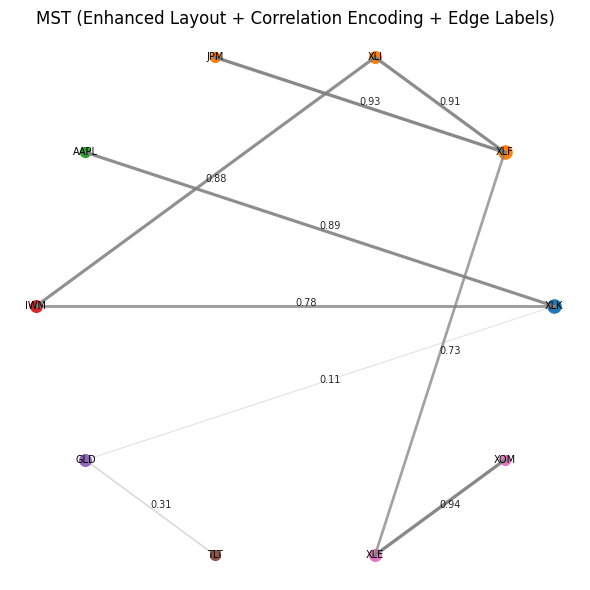


Plotting MST (spring layout)...


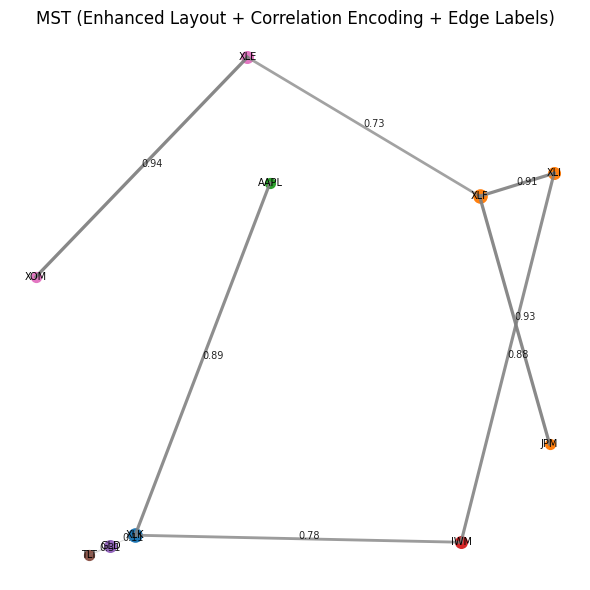


Plotting cluster time series...


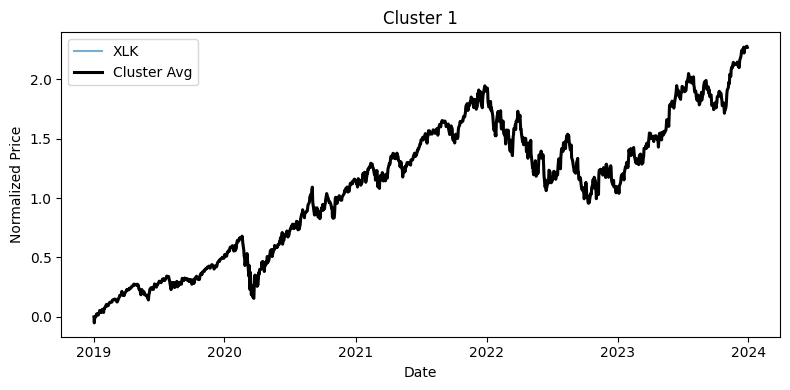

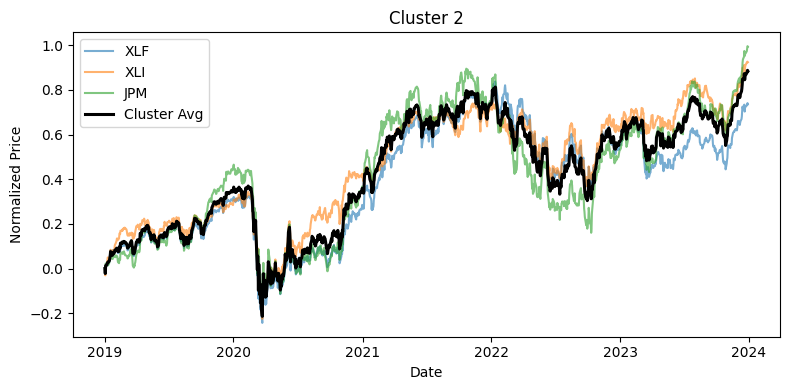

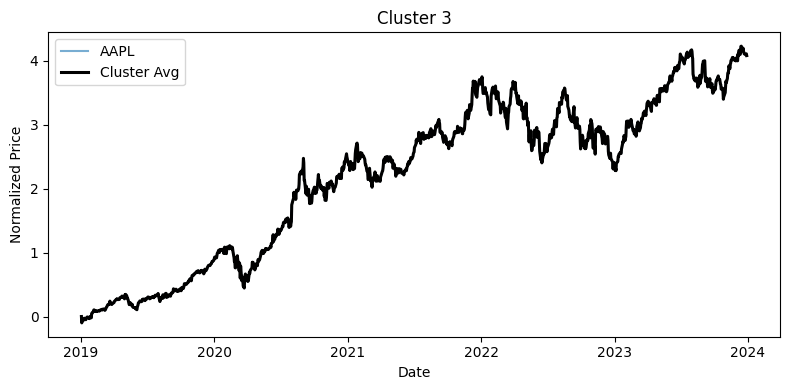

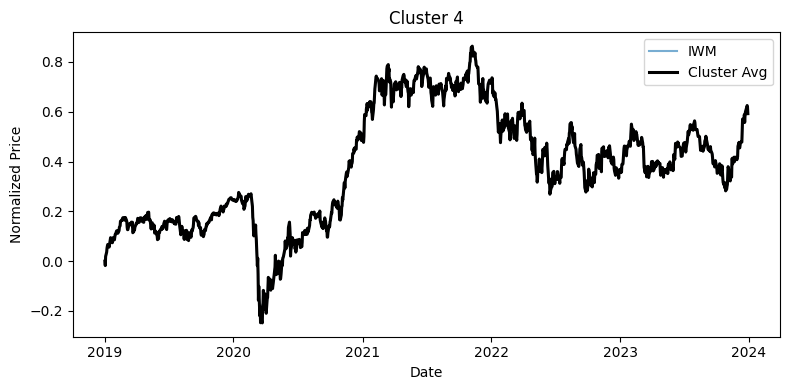

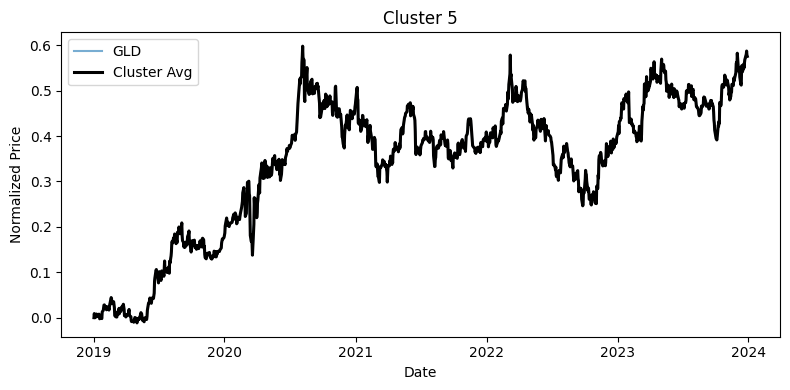

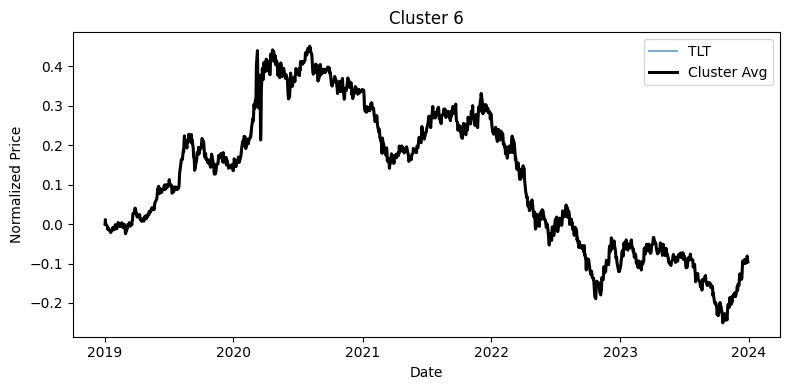

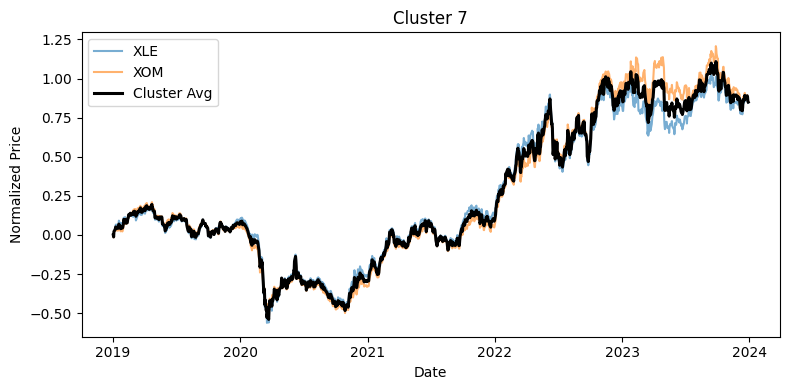

In [ ]:
def plot_mst_graph(mst_edges, clusters, layout="circle"):

    nodes = [n for g in clusters for n in g]
    N = len(nodes)

    # Node degrees for sizing
    degree = {n: 0 for n in nodes}
    for a, b, c, dist in mst_edges:
        degree[a] += 1
        degree[b] += 1

    # Layout selection

    # cite the below 2 lines from AI
    if layout == "circle":
        angles = np.linspace(0, 2*np.pi, N, endpoint=False)
        pos = {nodes[i]: (np.cos(angles[i]), np.sin(angles[i])) for i in range(N)}

    else:
      # Spring layout with minimal repulsion
      pos = {n: np.random.rand(2) * 2 - 1 for n in nodes}

      for _ in range(200):

          # repulsion between all nodes
          # edited the below part with AI

          for i in range(N):
              ni = nodes[i]
              xi, yi = pos[ni]
              for j in range(i + 1, N):
                  nj = nodes[j]
                  xj, yj = pos[nj]

                  dx, dy = xi - xj, yi - yj
                  d2 = dx*dx + dy*dy + 1e-6
                  rep = 0.002 / d2    # small repulsive force

                  # push nodes apart
                  pos[ni] = (xi + rep * dx, yi + rep * dy)
                  pos[nj] = (xj - rep * dx, yj - rep * dy)

          # Original Attractive Forces
          # edited the below part with AI

          for a, b, c, dist in mst_edges:
              x1, y1 = pos[a]
              x2, y2 = pos[b]

              dx, dy = x2 - x1, y2 - y1
              d = np.sqrt(dx*dx + dy*dy) + 1e-6
              force = 0.02 * (1 - abs(c))

              pos[a] = (x1 + force * dx / d, y1 + force * dy / d)
              pos[b] = (x2 - force * dx / d, y2 - force * dy / d)

    # Colors per cluster (same as your original)
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
              'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

    node_color = {}
    for idx, g in enumerate(clusters):
        for name in g:
            node_color[name] = colors[idx % len(colors)]

    plt.figure(figsize=(6, 6))

    # Draw edges
    # edited the below part with AI
    for a, b, c, dist in mst_edges:
        x1, y1 = pos[a]
        x2, y2 = pos[b]

        strength = abs(c)
        lw = 0.5 + 2 * strength
        alpha = max(0.25, strength)

        plt.plot([x1, x2], [y1, y2],
                 color='gray', linewidth=lw, alpha=alpha)

        # Draw correlation label at midpoint
        mx, my = (x1 + x2) / 2, (y1 + y2) / 2
        plt.text(mx, my, f"{c:.2f}",
                 fontsize=7, color="black", alpha=0.85)

    # Draw nodes
    for name, (x, y) in pos.items():
        node_size = 30 + degree[name] * 20
        plt.scatter(x, y, s=node_size, color=node_color[name])
        plt.text(x, y, name, fontsize=7, ha='center', va='center')

    plt.title("MST (Enhanced Layout + Correlation Encoding + Edge Labels)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def plot_cluster_time_series(price_df, clusters, normalize=False):

    # Plot time-series for each cluster with optional normalization (scale series to start at 1)

    for i, group in enumerate(clusters):
        plt.figure(figsize=(8, 4))

        # collect data for computing average
        series_list = []

        for ticker in group:
            if ticker in price_df.columns:
                s = price_df[ticker]

                # Normalization option
                # edited the below line with AI
                if normalize:
                    s = (s - s.iloc[0]) / s.iloc[0]

                plt.plot(price_df.index, s, label=ticker, alpha=0.6)
                series_list.append(s.values)

        # Plot cluster-average curve
        if len(series_list) > 0:
            avg_series = np.mean(series_list, axis=0)
            plt.plot(price_df.index, avg_series,
                     color='black', linewidth=2.2, label="Cluster Avg")

        plt.title(f"Cluster {i+1}")
        plt.xlabel("Date")
        plt.ylabel("Price" if not normalize else "Normalized Price")
        plt.legend()
        plt.tight_layout()
        plt.show()

# visualize MST (circle layout)
print("\nPlotting MST (circle layout)...")
plot_mst_graph(mst, clusters, layout="circle")

# visualize MST (spring layout)
print("\nPlotting MST (spring layout)...")
plot_mst_graph(mst, clusters, layout="spring")

# visualize cluster time series
print("\nPlotting cluster time series...")
plot_cluster_time_series(price_df, clusters, normalize=True)
